In [1]:
### Library import
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import glob
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import time
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

scale = 1.
orient = 10
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)
hist_bins = 32

C:\Users\rvm\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
### Reuse Functions

heatStore = []
def heatSave(heats):
    global heatStore
    if len(heatStore)>1:    
        if np.max(heats)==0.:
            val = heatStore[len(heatStore)-1]
        else:
            heatStore.append(heats)
            val = None
    else:
        val = heats
    
    return val

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    #print(bbox_list)
    count = 0
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        count +=1
    #print(count)
    # Return updated heatmap
    return heatmap

def add_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        #nonx, nonY = boxesAvg(nonzerox, nonzeroy)
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxArea = (np.max(nonzerox)-np.min(nonzerox))*(np.max(nonzeroy)-np.min(nonzeroy))
        # Draw the box on the image
        if bboxArea >80:
            cv2.rectangle(img, bbox[0], bbox[1], (255,255,255), 6)
    # Return the image
    return img

def hogSingle(img, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=True):
    hog_features = []
    hogFeats = []
    featImg = np.copy(img)
    for channel in range(featImg.shape[2]):
        hogCh = (hogFeatures(featImg[:,:,channel], 
                            orient, pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True))
        hogFeats.append(hogCh.ravel())
    hog_features = np.hstack((hogFeats[0],hogFeats[1],hogFeats[2]))
        
    return hog_features

def imgConv(img):
    imgColour = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)#YCrCb)
    dst = np.zeros_like(imgColour)
    b=cv2.normalize(imgColour,dst,0,255,cv2.NORM_MINMAX) 
    return imgColour

def hogFeatures(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(64, 46)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)
    scale_img = np.copy(img)
    img_tosearch = scale_img[ystart:ystop,:,:]
    ctrans_tosearch = imgConv(img_tosearch)
    imshape = ctrans_tosearch.shape
    bboxes = []
    heatmap = np.zeros((720,1280))
    for scale in ((0.8),(1.),(1.5),(2.)):
        
        img_tosearch = scale_img[ystart:ystop,:,:]
        ctrans_tosearch = imgConv(img_tosearch)
        imshape = ctrans_tosearch.shape
        #print('before: ',imshape)        
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        imshape = ctrans_tosearch.shape
        #print('after: ',imshape)
        #plt.imshow(ctrans_tosearch)
        #plt.show()
        if scale == 1.:
            ch1 = ctrans_tosearch[0:int(imshape[0]/2)-40,:,0]
            ch2 = ctrans_tosearch[0:int(imshape[0]/2)-40,:,1]
            ch3 = ctrans_tosearch[0:int(imshape[0]/2)-40,:,2]
            
        if scale == 1.5:
            ch1 = ctrans_tosearch[0:int(imshape[0]-80),:,0]
            ch2 = ctrans_tosearch[0:int(imshape[0]-80),:,1]
            ch3 = ctrans_tosearch[0:int(imshape[0]-80),:,2]
        
        if scale == 2.:
            ch1 = ctrans_tosearch[0:imshape[0],:,0]
            ch2 = ctrans_tosearch[0:imshape[0],:,1]
            ch3 = ctrans_tosearch[0:imshape[0],:,2]
            
        if scale == 0.8:
            ch1 = ctrans_tosearch[0:int(imshape[0])-110,:,0]
            ch2 = ctrans_tosearch[0:int(imshape[0])-110,:,1]
            ch3 = ctrans_tosearch[0:int(imshape[0])-110,:,2]
        

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = hogFeatures(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = hogFeatures(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = hogFeatures(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
                #plt.imshow(subimg)
                #plt.show()
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1)) 
                #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 

                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)
                if test_prediction == 1:
                    #print('Found Something')
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    boxCenterX = ((xbox_left)+(xbox_left+win_draw))/2
                    #print(boxCenterX)
                    boxCenterY = ((ytop_draw+ystart)+(ytop_draw+win_draw+ystart))/2
                    #print(boxCenterY)
                    FlagNotAppendBox = 0
                    if ((boxCenterX > 50) and (boxCenterX < 700)):
                        if (boxCenterY>400):
                            FlagNotAppendBox = 1
                    if FlagNotAppendBox == 0:   
                        bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                        if scale == 0.8:
                            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,255,255),6)
                        if scale == 1.:
                            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,0),6)
                        if scale == 1.5:
                            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,255,0),6)
                        if scale == 2.:
                            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                        #plt.imshow(subimg)
                        #plt.show()
        ctrans_tosearch = None
    heats = add_heat(heatmap, bboxes)
    heats2 = add_threshold(heats,threshold=4)
    if (np.max(heats2))==1:
        heats2 = heatSave(heats2)
    else:
        heatSave(heats2)
    labels = label(heats2)
    #print(np.shape(labels[0]))
    #print(np.shape(labels))
    outout = draw_labeled_bboxes(scale_img,labels)
    return outout

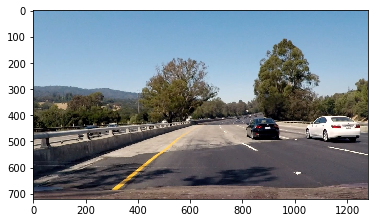

In [3]:
### Importing Test Images

wd = 'C:\\Users\\rvm\\Documents\\Ruan\\Udacity\\Self-Driving Car\\VehicleDetectionAndTracking\\CarND-Vehicle-Detection\\'
imgFolder = 'test_images\\'
testImages = []
for i in range(1,7):
    filename = wd+imgFolder+'test'+str(i)+'.jpg'
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    testImages.append(img)
    
index = random.randint(0, len(testImages)-1)
plt.imshow(testImages[index])
plt.show()


The total dataset has:  11391  images.
The amount of vehicle images is:  7491
The amount of non-vehicle images is:  3900
The shape of the images are:  (64, 64, 3)



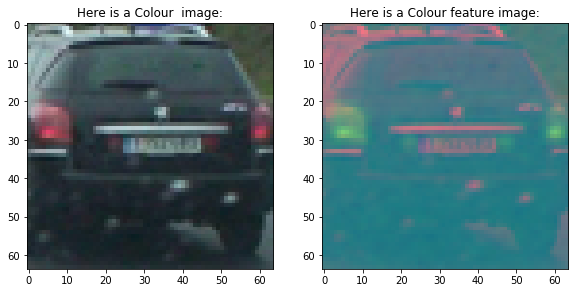

In [4]:
### Importing Training Images

clfCarImagesFar = glob.glob('C:\\Users\\rvm\\Documents\\Ruan\\Udacity\\Self-Driving Car\\VehicleDetectionAndTracking\\CarND-Vehicle-Detection\\vehicles\\vehicles\\GTI_Far\\*.png')
clfCarImagesLeft = glob.glob('C:\\Users\\rvm\\Documents\\Ruan\\Udacity\\Self-Driving Car\\VehicleDetectionAndTracking\\CarND-Vehicle-Detection\\vehicles\\vehicles\\GTI_Left\\*.png')
clfCarImagesMidClo = glob.glob('C:\\Users\\rvm\\Documents\\Ruan\\Udacity\\Self-Driving Car\\VehicleDetectionAndTracking\\CarND-Vehicle-Detection\\vehicles\\vehicles\\GTI_MiddleClose\\*.png')
clfCarImagesRight = glob.glob('C:\\Users\\rvm\\Documents\\Ruan\\Udacity\\Self-Driving Car\\VehicleDetectionAndTracking\\CarND-Vehicle-Detection\\vehicles\\vehicles\\GTI_Right\\*.png')
clfCarImagesKit = glob.glob('C:\\Users\\rvm\\Documents\\Ruan\\Udacity\\Self-Driving Car\\VehicleDetectionAndTracking\\CarND-Vehicle-Detection\\vehicles\\vehicles\\KITTI_extracted\\*.png')
clfNcarImages = glob.glob('C:\\Users\\rvm\\Documents\\Ruan\\Udacity\\Self-Driving Car\\VehicleDetectionAndTracking\\CarND-Vehicle-Detection\\non-vehicles\\non-vehicles\\GTI\\*.png')
carsx = []
ncarsx = []
for imgs in clfCarImagesFar:
    carsx.append(imgConv(cv2.cvtColor(cv2.imread(imgs),cv2.COLOR_BGR2RGB)))
for imgs in clfCarImagesLeft:
    carsx.append(imgConv(cv2.cvtColor(cv2.imread(imgs),cv2.COLOR_BGR2RGB)))
for imgs in clfCarImagesMidClo:
    carsx.append(imgConv(cv2.cvtColor(cv2.imread(imgs),cv2.COLOR_BGR2RGB)))
for imgs in clfCarImagesRight:
    carsx.append(imgConv(cv2.cvtColor(cv2.imread(imgs),cv2.COLOR_BGR2RGB)))
    carsx.append(imgConv(cv2.cvtColor(cv2.imread(imgs),cv2.COLOR_BGR2RGB)))
count=0
for imgs in clfCarImagesKit:
    count+=1
    carsx.append(imgConv(cv2.cvtColor(cv2.imread(imgs),cv2.COLOR_BGR2RGB)))
    if count>4000:
        count
        break 

count2 = 0
for imgs in clfNcarImages:  
    count2+=1
    ncarsx.append(imgConv(cv2.cvtColor(cv2.imread(imgs),cv2.COLOR_BGR2RGB)))
    #ncarsx.append(np.fliplr(imgConv(cv2.cvtColor(cv2.imread(imgs),cv2.COLOR_BGR2RGB))))
    carsx.append(imgConv(cv2.cvtColor(cv2.imread(imgs),cv2.COLOR_BGR2RGB)))
    #carsx.append(np.fliplr(imgConv(cv2.cvtColor(cv2.imread(imgs),cv2.COLOR_BGR2RGB))))
    if count2>10000:
        count2
        break 

carsy = np.ones(len(carsx)-len(ncarsx),)
ncarsy = np.zeros(len(ncarsx),)
xTrain = carsx
yTrain = np.append(carsy, ncarsy)
r = random.random()
random.shuffle(xTrain, lambda : r)
random.shuffle(yTrain, lambda : r)


featuresA = []
for k in range(0,len(xTrain)):
    img = np.copy(xTrain[k])
    imgFeats = imgConv(img)
    hogFeat = hogSingle(imgFeats, orient, pix_per_cell, cell_per_block, feature_vec=False)
    histFeat = color_hist(imgFeats, nbins=32)
    spatialFeat = bin_spatial(imgFeats, size=(32, 32))
    featuresA.append((np.hstack((histFeat, hogFeat))))
    #featuresA.append((np.hstack((spatialFeat, histFeat, hogFeat))))

scaler = StandardScaler().fit(featuresA)
features = scaler.transform(featuresA)

index = random.randint(0,len(xTrain))
print('The total dataset has: ',len(yTrain),' images.')
print('The amount of vehicle images is: ',len(carsx)-len(ncarsx))
print('The amount of non-vehicle images is: ',len(ncarsx))
print('The shape of the images are: ',np.shape(xTrain[1]))
print()
ind = random.randint(0,len(xTrain))
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.title('Here is a Colour  image:')
plt.imshow(cv2.cvtColor(xTrain[ind],cv2.COLOR_YCrCb2RGB)) #YCrCb
plt.subplot(1,3,2)
plt.title('Here is a Colour feature image:')
plt.imshow(xTrain[ind])
#plt.subplot(1,3,3)
#plt.title('Here is a HOG feature image:')
#plt.imshow(hogImgs[ind])
plt.show()

In [5]:
### Training the Classifier
x_train, x_test, y_train, y_test = train_test_split(features, yTrain, test_size=0.25)
print('The number of Training data: ', len(x_train))
print('The number of Testing data: ', len(x_test))
'''
svc = LinearSVC()
'''
svc = LinearSVC(C=1.7, class_weight=None, dual=True, fit_intercept=True,
                intercept_scaling=1, loss='squared_hinge',
                multi_class='ovr', penalty='l2', random_state=None, tol=0.00001,
                verbose=0)

#svc = SVC(C=1.0, gamma='auto', kernel='rbf', verbose=False)

# Check the training time for the SVC
t=time.time()
svc.fit(x_train, y_train)
t2 = time.time()
print('Total time for training SVC =',round(t2-t,3),'seconds')
print('The accuracy of the SVC = ', round(svc.score(x_test,y_test),4))

The number of Training data:  8543
The number of Testing data:  2848
Total time for training SVC = 15.873 seconds
The accuracy of the SVC =  0.9853


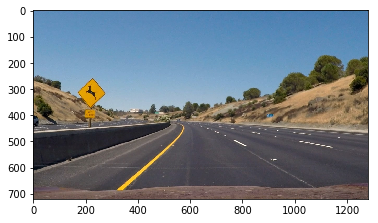

In [6]:
imgNum = 1
plt.imshow(testImages[imgNum])
plt.show()

In [7]:
### Main Function
imshapes = (np.shape(testImages[imgNum]))

ystart = int(imshapes[0]*0.5)
ystop = imshapes[0]

def out_img(img, ystart=ystart, ystop=ystop, scale=scale, svc=svc, X_scaler=scaler, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins):
    
    oout = find_cars(img, ystart=ystart, ystop=ystop, scale=scale, svc=svc, X_scaler=scaler, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins)

    return oout

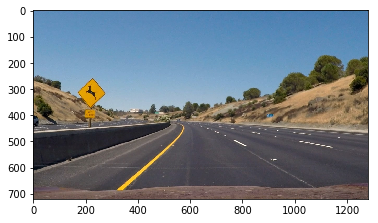

In [8]:
plt.imshow(out_img(testImages[imgNum]))
plt.show()
#plt.imshow(cleanImg,cmap='hot')
#plt.show()



In [9]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'p15Result.mp4'
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(out_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)



[MoviePy] >>>> Building video p15Result.mp4
[MoviePy] Writing video p15Result.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:44:01<00:04,  4.53s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: p15Result.mp4 

Wall time: 1h 44min 2s


1.0


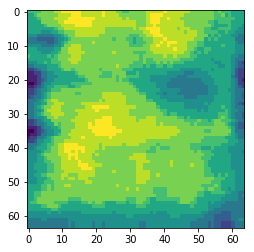

In [10]:
ind = random.randint(0,len(xTrain))

p = xTrain[ind]
print(yTrain[ind])
plt.imshow((p[:,:,2]))
plt.show()